When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. 

In [ ]:
from typing import Annotated
from dotenv import load_dotenv
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

load_dotenv(override=True)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

Then add nodes. Nodes are units of work in langgraph.

In [8]:
from langchain_openai import ChatOpenAI


def chat_bot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


Adding nodes and edges to the graph

In [9]:
from langgraph.graph import END
from langgraph.graph import START

graph_builder.add_node("chat_bot", chat_bot)
graph_builder.add_edge(START, "chat_bot")
graph_builder.add_edge("chat_bot", END)

In [4]:
graph = graph_builder.compile()

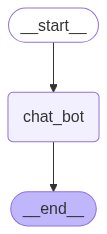

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import gradio as gr

def chat(message, history):
    partial_response = ""
    for event in graph.stream({"messages": [{"role": "user", "content": message}]}):
        for value in event.values():
            partial_response += value["messages"][-1].content
            yield partial_response
    


chat_interface = gr.ChatInterface(chat, type="messages", theme="soft")
chat_interface.launch()

In [22]:
chat_interface.close()

Closing server running on port: 7861
